# Entrega 3 Machine Learning para IA - Kaggle Submission

### Ramiro Sanes (368397) y Joaquin Guerra (307854)

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import joblib
import imageio.v2 as imageio

from tqdm import tqdm

from skimage import data, color, feature
from skimage.transform import resize

from sklearn.decomposition import PCA   
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.pipeline import Pipeline
from imblearn.metrics import geometric_mean_score
from sklearn.naive_bayes import GaussianNB

from utils import extract_patches

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from redes import FaceClassifierNN

plt.style.use('ggplot')



In [2]:
def guardar_pipeline(scaler,pca,modelo,nombre):
    """
    Guarda el pipeline del modelo, el escalador y el PCA en un archivo .pkl.
    """
    pipeline = Pipeline([
    ('scaler', scaler),
    ('pca', pca),
    ('clf', modelo)
])
    joblib.dump(pipeline, f'modelos/{nombre}.pkl')
    print(f"Pipeline guardado como '{nombre}.pkl'")

## Tarea 1

Generar un conjunto de datos con imagenes de fondo (sin rostros)

In [3]:
images = []

# Creamos el directorio de Background si no existe
if not os.path.exists('Background'):
    os.makedirs('Background')
    #Descargamos el archivo zip de Background
    with zipfile.ZipFile('Background.zip', 'r') as zip_ref:
        zip_ref.extractall('Background')

# Cargamos imagenes de sklearn
imgs = ['text',
        'coins',
        'moon',
        'page',
        'clock',
        'immunohistochemistry',
        'chelsea',
        'coffee',
        'hubble_deep_field',
        #'astronaut',
        ]

for name in imgs:
    img = getattr(data, name)()
    if len(img.shape) == 3 and img.shape[2] == 3:  # Chequeamos si la imagen es RGB
        img = color.rgb2gray(img)
    images.append(resize(img, (100,100)))

# Cargamos imagenes de Background
# iteramos en todas las files de background
for file in os.listdir('Background'):
    if file.endswith('.jpg'):
        filename = os.path.join('Background', file)
        img = plt.imread(filename)
        if len(img.shape) == 3 and img.shape[2] == 3:  # Chequeamos si la imagen es RGB
            img = color.rgb2gray(img)
        images.append(resize(img, (100,100)))

# Extraemos las imágenes de fondo
negative_patches = np.vstack([extract_patches(im, 300, scale) for im in tqdm(images, desc='Procesando imágenes') for scale in [0.1,0.25,0.5,0.75,1]])
negative_patches.shape


Procesando imágenes: 100%|██████████| 40/40 [00:08<00:00,  4.83it/s]


(60000, 64, 64)

## Tarea 2

Evaluar la técnica de componentes principales (PCA) para la clasificacion de rostros

In [4]:
faces = []

#Cargamos caras
if not os.path.exists('Faces'):
    os.makedirs('Faces')
    with zipfile.ZipFile('Faces.zip', 'r') as zip_ref:
        zip_ref.extractall()


all_files = os.listdir('Faces')
pgm_files = [filename for filename in all_files if filename.endswith('.pgm')]

for filename in tqdm(pgm_files):
    path = os.path.join('Faces', filename)
    image = imageio.imread(path)
    faces.append(image)

faces_array = np.stack(faces)
faces_array = faces_array / 255.0

  0%|          | 0/12833 [00:00<?, ?it/s]

 28%|██▊       | 3562/12833 [00:02<00:07, 1205.20it/s]


KeyboardInterrupt: 

In [ ]:
  # Etiquetas para las imágenes de rostros
X_faces = faces_array
y_faces = [1] * len(X_faces)

 # Etiquetas para las imágenes de fondo
X_fondos = negative_patches
y_fondos = [0] * len(X_fondos)

# Etiquetas combinadas
X = np.vstack([X_faces,X_fondos])
y = np.hstack([y_faces,y_fondos])

In [ ]:
hog_features = []
for img in tqdm(X, desc='Extrayendo HOG features'):
    fd = feature.hog(img, visualize=False)
    hog_features.append(fd)


Extrayendo HOG features: 100%|██████████| 72833/72833 [01:06<00:00, 1094.38it/s]


In [ ]:
#Pasamos la lista a un array de numpy
hog_features = np.vstack(hog_features)


In [ ]:
# Guardamos el dataset total para luego de la seleccion y validacion volver a entrenar con todo el dataset
X_total = hog_features
y_total = y

Separamos el set en Train y Validación utilizando el 10% para lo segundo

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(hog_features, y, test_size=0.1, random_state=42)

Creamos el Scaler

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

Probamos PCA con 500 componentes para obtener la cantidad de componentes que explique el 95% de la varianza del set

In [ ]:
pca = PCA(n_components=500)
pca.fit(X_train)

PCA(n_components=500)

In [ ]:
pca_idx = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) +1
print(f"El número de componentes principales que explican al menos el 95% de la varianza es: {pca_idx}")

El número de componentes principales que explican al menos el 95% de la varianza es: 459


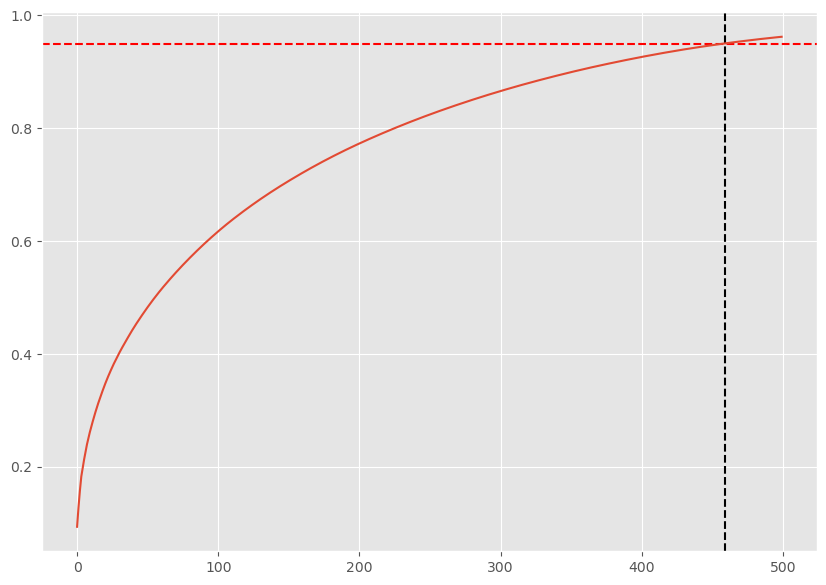

In [ ]:
fig, ax = plt.subplots(1, figsize=(10, 7))
ax.axhline(y=0.95, color='r', linestyle='--', label='95%')
ax.axvline(x=459, color='k', linestyle='--', label='x = 459')
plt.plot(np.cumsum(pca.explained_variance_ratio_), label=f'{500} componentes')
plt.show()

Tomamos 459 como la cantidad de componentes principales ya que pasa el umbral definido de 95% de la varianza explicada

In [ ]:
pca_final = PCA(n_components=pca_idx)
X_pca_train = pca_final.fit_transform(X_train)
X_pca_val = pca_final.transform(X_val)

In [ ]:
print(f'Las primeras 3 componentes del PCA elegido explican el {float(np.cumsum(pca_final.explained_variance_ratio_)[2] *100):.2f}% de la varianza')

Las primeras 3 componentes del PCA elegido explican el 15.78% de la varianza


### Visualizamos las primeras componentes

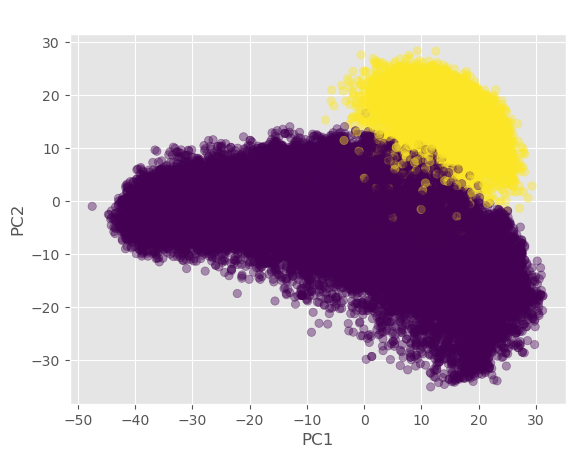

In [ ]:
X_pca_train = pca_final.transform(X_train)

plt.scatter(X_pca_train[:,0], X_pca_train[:,1], alpha=0.4,c=y_train)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Proyección')
plt.show()

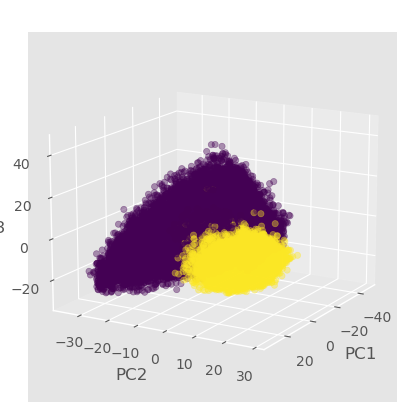

In [ ]:
# Plot 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


ax.scatter(X_pca_train[:,0], X_pca_train[:,1], X_pca_train[:,2], alpha=0.4,c=y_train)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

ax.view_init(elev=15, azim=30)

ax.set_title('PCA - Primeras 3 componentes')
plt.show()

## Modelos sencillo de clasificación

### Árboles de Decisión

Entrenamos 3 árboles de decision, de profundidad 2, 5 y 10:

Entrenamos 3 árboles de decision, de profundidad 2, 5 y 10. Utilizamos validación cruzada para evaluar el rendimiento de cada modelo y luego los evaluamos en el conjunto de validación.
Utilizamos f1 score como métrica de evaluación, ya que es más adecuada para conjuntos de datos desbalanceados como el nuestro.

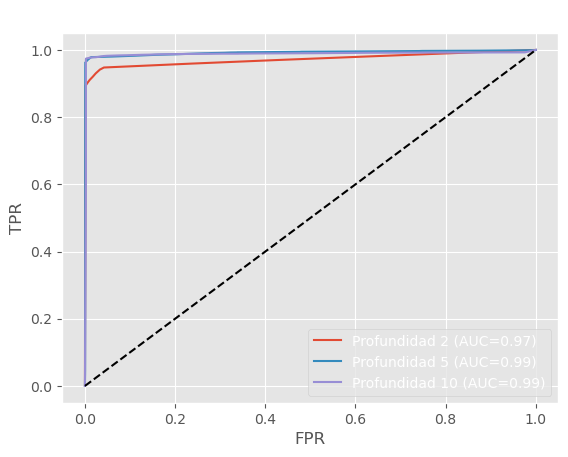


 Resultados:

 Profundidad 2:
  Accuracy: 0.9800
  TPR: 0.8939
  FPR: 0.0015
  AUC: 0.9710
  G-Mean: 0.9447
  F1 Score: 0.9406

 Profundidad 5:
  Accuracy: 0.9925
  TPR: 0.9625
  FPR: 0.0011
  AUC: 0.9917
  G-Mean: 0.9805
  F1 Score: 0.9784

 Profundidad 10:
  Accuracy: 0.9934
  TPR: 0.9732
  FPR: 0.0023
  AUC: 0.9878
  G-Mean: 0.9854
  F1 Score: 0.9812

 El mejor árbol f1 score: 10 (F1 Score = 0.9812)


In [ ]:
X = X_pca_train
y = y_train

depths = [2, 5, 10]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = {}
best_f1 = -1
best_depth = None

for depth in depths:
    acc, tprs, fprs, aucs, gmeans, f1s = [], [], [], [], [], []
    all_true, all_probs = [], []

    for train_idx, val_idx in cv.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train_cv, y_val = y[train_idx], y[val_idx]

        model = DecisionTreeClassifier(max_depth=depth, random_state=42)
        model.fit(X_train, y_train_cv)
        y_pred = model.predict(X_val)
        y_proba = model.predict_proba(X_val)[:, 1]

        # Confusion matrix para TPR y FPR
        tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
        TPR = tp / (tp + fn) if (tp + fn) != 0 else 0
        FPR = fp / (fp + tn) if (fp + tn) != 0 else 0

        acc.append(accuracy_score(y_val, y_pred))
        tprs.append(TPR)
        fprs.append(FPR)
        aucs.append(roc_auc_score(y_val, y_proba))
        gmeans.append(geometric_mean_score(y_val, y_pred))
        f1s.append(f1_score(y_val, y_pred))

        all_true.extend(y_val)
        all_probs.extend(y_proba)

    # Guardamos los resultados en un diccionario
    results[depth] = {
        'Accuracy' : np.mean(acc),
        'TPR': np.mean(tprs),
        'FPR': np.mean(fprs),
        'AUC': np.mean(aucs),
        'G-Mean': np.mean(gmeans),
        'F1 Score' : np.mean(f1s),
    }

    # Elegimos por el mejor F1 Score
    if results[depth]['F1 Score'] > best_f1:
        best_f1 = results[depth]['F1 Score']
        best_depth = depth
        best_model = model

    # Graficamos la curva ROC
    fpr_curve, tpr_curve, _ = roc_curve(all_true, all_probs)
    plt.plot(fpr_curve, tpr_curve, label=f'Profundidad {depth} (AUC={results[depth]["AUC"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Curvas ROC por profundidad")
plt.legend()
plt.grid(True)
plt.show()

# Print Resultados arboles
print("\n Resultados:")
for depth, metrics in results.items():
    print(f"\n Profundidad {depth}:")
    for m, v in metrics.items():
        print(f"  {m}: {v:.4f}")

print(f"\n El mejor árbol f1 score: {best_depth} (F1 Score = {best_f1:.4f})")

### Gaussian NB

Entrenamos Gaussian NB con 2 configuraciones de hiper parámetros distintas:

In [ ]:
models = {
    'default': GaussianNB(),
    'var_smoothing_1e-5': GaussianNB(var_smoothing=1e-5),
#    'var_smoothing_1e-9': GaussianNB(var_smoothing=1e-9),
}

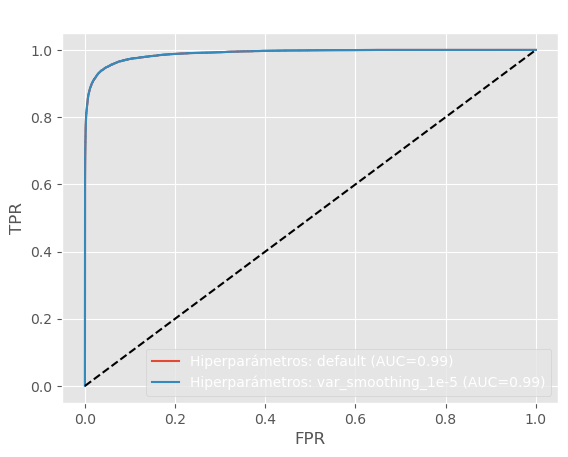


 Resultados:

 Hiperparametros: default:
  Accuracy: 0.9654
  TPR: 0.9214
  FPR: 0.0251
  AUC: 0.9899
  G-Mean: 0.9478
  F1 Score: 0.9040

 Hiperparametros: var_smoothing_1e-5:
  Accuracy: 0.9654
  TPR: 0.9225
  FPR: 0.0254
  AUC: 0.9899
  G-Mean: 0.9482
  F1 Score: 0.9041

 Mejor sesgo inductivo según f1 score: var_smoothing_1e-5 (F1 Score = 0.9041)


In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results_gaussian_nb = {}
best_f1 = -1
best_hiperparam = None


for key,model in models.items():
    acc, tprs, fprs, aucs, gmeans, f1s = [], [], [], [], [], []
    all_true, all_probs = [], []

    for train_idx, val_idx in cv.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train_cv, y_val = y[train_idx], y[val_idx]

        model.fit(X_train, y_train_cv)
        y_pred = model.predict(X_val)
        y_proba = model.predict_proba(X_val)[:, 1]

        # Confusion matrix para TPR y FPR
        tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
        TPR = tp / (tp + fn) if (tp + fn) != 0 else 0
        FPR = fp / (fp + tn) if (fp + tn) != 0 else 0

        acc.append(accuracy_score(y_val, y_pred))
        tprs.append(TPR)
        fprs.append(FPR)
        aucs.append(roc_auc_score(y_val, y_proba))
        gmeans.append(geometric_mean_score(y_val, y_pred))
        f1s.append(f1_score(y_val, y_pred))

        all_true.extend(y_val)
        all_probs.extend(y_proba)

    # Guardamos los resultados en un diccionario
    results_gaussian_nb[key] = {
        'Accuracy' : np.mean(acc),
        'TPR': np.mean(tprs),
        'FPR': np.mean(fprs),
        'AUC': np.mean(aucs),
        'G-Mean': np.mean(gmeans),
        'F1 Score' : np.mean(f1s),
    }

    # Usamos nuevamente el f1 score como metrica de seleccion
    if results_gaussian_nb[key]['F1 Score'] > best_f1:
        best_f1 = results_gaussian_nb[key]['F1 Score']
        best_hiperparam = key
        best_model = model

    fpr_curve, tpr_curve, _ = roc_curve(all_true, all_probs)
    plt.plot(fpr_curve, tpr_curve, label=f'Hiperparámetros: {key} (AUC={results_gaussian_nb[key]["AUC"]:.2f})')


plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Curvas ROC por profundidad")
plt.legend()
plt.grid(True)
plt.show()

# Mostrar resultados
print("\n Resultados:")
for key, metrics in results_gaussian_nb.items():
    print(f"\n Hiperparametros: {key}:")
    for m, v in metrics.items():
        print(f"  {m}: {v:.4f}")

print(f"\n Mejor sesgo inductivo según f1 score: {best_hiperparam} (F1 Score = {best_f1:.4f})")

# Utilizamos GridSearchCV

Entrenamos:

    - RandomForest: 4 configuraciones de hiperparámetros
    - XGBoost: 8 configuraciones de hiperparámetros
    - LogisticRegression: 6 configuraciones de hiperparámetros

GRID SEARCH

In [ ]:
# Lista de modelos y sus grids
models_and_parameters = {
    "RandomForest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [5, 10],
        },
    },
    "XGBoost": {
        "model": xgb.XGBClassifier(eval_metric="logloss", random_state=42),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [3, 6],
            "learning_rate": [0.1, 0.2],
        },
    },

    "LogisticRegression": {
        "model": LogisticRegression(solver="liblinear", random_state=42),
        "params": {
            "C": [0.1, 1, 10],
            "penalty": ["l1", "l2"],
        },
    },
}

In [ ]:
results = []
mejor_modelo = None
mejor_score = -1
mejor_nombre = ""
mejor_params = None

for model_name, mp in models_and_parameters.items():
    print(f"{model_name}")


    grid = GridSearchCV(
        estimator=mp["model"],
        param_grid=mp["params"],
        scoring="f1",
        cv=3,
        n_jobs=-1,
        verbose=2,
    )

    grid.fit(X_pca_train, y_train)
    y_pred = cross_val_predict(grid.best_estimator_, X_pca_train, y_train, cv=3, method="predict")
    y_proba = cross_val_predict(grid.best_estimator_, X_pca_train, y_train, cv=3, method="predict_proba")[:, 1]



    # Matriz de confusión
    tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0
    gmean = np.sqrt(tpr * (tn / (fp + tn))) if (fp + tn) > 0 else 0.0
    auc = roc_auc_score(y_train, y_proba)

    acc = accuracy_score(y_train, y_pred)
    f1 = f1_score(y_train, y_pred)


    # Guardar resultados del modelo actual
    results.append({
        "model": model_name,
        "best_params": grid.best_params_,
        "best_score_f1_cv": grid.best_score_,
        "accuracy": acc,
        "tpr": tpr,
        "fpr": fpr,
        "auc": auc,
        "gmean": gmean,
        "modelo_entrenado": grid.best_estimator_,
    })

    # Evaluar si es el mejor modelo global utilizando el F1 score
    if grid.best_score_ > mejor_score:
        mejor_score = grid.best_score_
        mejor_modelo = grid.best_estimator_
        mejor_nombre = model_name
        mejor_params = grid.best_params_


# ✅ Imprimir el resumen final
print(f"\n Mejor modelo global de GridSearch: {mejor_nombre}")
print(f"F1 score (CV): {mejor_score:.4f}")
print("Mejores hiperparámetros:")
for k, v in mejor_params.items():
    print(f"  {k}: {v}")

RandomForest
Fitting 3 folds for each of 4 candidates, totalling 12 fits
XGBoost
Fitting 3 folds for each of 8 candidates, totalling 24 fits
LogisticRegression
Fitting 3 folds for each of 6 candidates, totalling 18 fits

 Mejor modelo global de GridSearch: LogisticRegression
F1 score (CV): 0.9924
Mejores hiperparámetros:
  C: 0.1
  penalty: l1


Guardamos las métricas y el mejor modelo para cada uno de los algoritmos probados en el dataframe df_results

In [ ]:
df_results

NameError: name 'df_results' is not defined

Utilizamos la funcion definida en la notebook "guardar_pipeline" para guardar los modelos de XGBoost y LogisticRegression

In [ ]:
guardar_pipeline(scaler, pca_final, df_results.modelo_entrenado[1], 'pipeline_XGB_20250701')

Pipeline guardado como 'pipeline_XGB_20250701.pkl'


In [ ]:
guardar_pipeline(scaler, pca_final, df_results.modelo_entrenado[2], 'pipeline_LReg_20250701')

Pipeline guardado como 'pipeline_LReg_20250701.pkl'


# Probamos con Redes Neuronales utilizando PyTorch

In [ ]:
# Convertimos los datos a tensores de PyTorch
X_train_tensor = torch.tensor(X_pca_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # para clasificación
X_test_tensor = torch.tensor(X_pca_val, dtype=torch.float32)
y_test_tensor = torch.tensor(y_val, dtype=torch.long)

In [ ]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [ ]:
modelo_rn_1 = FaceClassifierNN(447,256,1)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(modelo_rn_1.parameters(), lr=0.001)

In [ ]:
# Entrenamiento
epochs = 20
for epoch in range(epochs):
    modelo_rn_1.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_batch = y_batch.float() 
        outputs = modelo_rn_1(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs} - Loss: {running_loss:.4f}")

Epoch 1/20 - Loss: 31.7525
Epoch 2/20 - Loss: 4.1783
Epoch 3/20 - Loss: 2.2704
Epoch 4/20 - Loss: 2.0803
Epoch 5/20 - Loss: 1.0262
Epoch 6/20 - Loss: 1.3154
Epoch 7/20 - Loss: 1.2180
Epoch 8/20 - Loss: 0.7599
Epoch 9/20 - Loss: 0.4097
Epoch 10/20 - Loss: 1.0053
Epoch 11/20 - Loss: 0.7753
Epoch 12/20 - Loss: 0.5498
Epoch 13/20 - Loss: 0.5646
Epoch 14/20 - Loss: 0.4747
Epoch 15/20 - Loss: 0.4255
Epoch 16/20 - Loss: 0.7137
Epoch 17/20 - Loss: 0.3745
Epoch 18/20 - Loss: 0.2299
Epoch 19/20 - Loss: 0.3676
Epoch 20/20 - Loss: 0.3357


In [ ]:
# Evaluación
modelo_rn_1.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = modelo_rn_1(X_batch).squeeze()
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).int()
        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.int().cpu().numpy())

# Calculamos las mismas metricas que antes
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
auc = roc_auc_score(all_labels, all_probs)

tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()

tpr = tp / (tp + fn) if (tp + fn) > 0 else 0.0 
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0
gmean = np.sqrt(tpr * (tn / (fp + tn))) if (fp + tn) > 0 else 0.0

# Imprimimos los resultados
print(f"\n Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")
print(f"TPR (Recall): {tpr:.4f}")
print(f"FPR: {fpr:.4f}")
print(f"G-Mean: {gmean:.4f}")


Accuracy: 0.9990
F1 Score: 0.9969
AUC: 0.9997
TPR (Recall): 0.9969
FPR: 0.0006
G-Mean: 0.9982


Guardamos los pesos de la red

In [ ]:
# Guardar solo los pesos del modelo
torch.save(modelo_rn_1.state_dict(), "modelos/nn_20250628.pth")

## Segunda Red

In [ ]:

modelo_rn_2 = FaceClassifier2NN()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(modelo_rn_2.parameters(), lr=1e-3)

In [ ]:
# Entrenamiento
epochs = 20
for epoch in range(epochs):
    modelo_rn_2.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_batch = y_batch.float() 
        outputs = modelo_rn_2(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs} - Loss: {running_loss:.4f}")

Epoch 1/20 - Loss: 41.9076
Epoch 2/20 - Loss: 10.5248
Epoch 3/20 - Loss: 6.2998
Epoch 4/20 - Loss: 5.0349
Epoch 5/20 - Loss: 4.1332
Epoch 6/20 - Loss: 2.7515
Epoch 7/20 - Loss: 2.9978
Epoch 8/20 - Loss: 1.8892
Epoch 9/20 - Loss: 2.3346
Epoch 10/20 - Loss: 1.9930
Epoch 11/20 - Loss: 1.7024
Epoch 12/20 - Loss: 1.3877
Epoch 13/20 - Loss: 1.1160
Epoch 14/20 - Loss: 1.5500
Epoch 15/20 - Loss: 1.1509
Epoch 16/20 - Loss: 1.2125
Epoch 17/20 - Loss: 1.1556
Epoch 18/20 - Loss: 0.8930
Epoch 19/20 - Loss: 0.9667
Epoch 20/20 - Loss: 0.5674


In [ ]:
# Evaluación
modelo_rn_2.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = modelo_rn_2(X_batch).squeeze()
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).int()
        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.int().cpu().numpy())

# Calculamos las mismas metricas que antes
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
auc = roc_auc_score(all_labels, all_probs)

tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()

tpr = tp / (tp + fn) if (tp + fn) > 0 else 0.0 
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0
gmean = np.sqrt(tpr * (tn / (fp + tn))) if (fp + tn) > 0 else 0.0

# Imprimimos los resultados
print(f"\n Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")
print(f"TPR (Recall): {tpr:.4f}")
print(f"FPR: {fpr:.4f}")
print(f"G-Mean: {gmean:.4f}")


Accuracy: 0.9993
F1 Score: 0.9977
AUC: 0.9998
TPR (Recall): 0.9969
FPR: 0.0003
G-Mean: 0.9983


In [ ]:
# Guardar solo los pesos del modelo
torch.save(modelo_rn_2.state_dict(), "modelos/nn_20250701_v2.pth")